## まとめ
* 計算グラフを用いれば、計算過程を視覚的に把握することができる
* 計算グラフのノードは局所的な計算によって構成される。局所的な計算が全体の計算を構成する。
* 計算グラフの順伝搬は、通常の計算を行う。一方、計算グラフの逆伝搬によって、各ノードの微分を求めることができる。
* ニューラルネットワークの構成要素をレイヤとして実装することで、勾配の計算を効率的に求めることができる
* 数値微分と誤差逆伝播法の結果を比較することで、誤差逆伝播法の実装に誤りがないことを確認できる 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys,os

ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL/deep-learning-from-scratch/'
sys.path.append(ROOT_PATH)
sys.path.append(os.pardir)

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

## 単純なレイヤの実装

In [ ]:
#乗算レイヤの実装
class MulLayer:
  def __init__(self):
    self.x=None   #インスタンスｘ，ｙの初期化
    self.y=None

  def forward(self,x,y):
    self.x=x    #乗算レイヤの逆伝搬には入力の値が必要なので、インスタンスとして値を保持
    self.y=y
    out=x*y
    return out

  def backward(self,dout):
    dx=dout*self.y    #入力x,yをひっくり返して掛ける
    dy=dout*self.x

    return dx,dy

In [ ]:
#りんご２つの値段に消費税（１０％）を掛けたときの処理
apple=100
apple_num=2
tax=1.1

#layer
mul_apple_layer=MulLayer()
mul_tax_layer=MulLayer()

#forward
apple_price=mul_apple_layer.forward(apple,apple_num)
price=mul_tax_layer.forward(apple_price,tax)

print('price=',price)

#backward
dprice=1    #合計金額（dout）を１とすると、各入力が微少に変わったときの合計金額の変化量（微分）が出る
dapple_price,dtax=mul_tax_layer.backward(dprice)
dapple,dapple_num=mul_apple_layer.backward(dapple_price)

print('dapple=',dapple,'dapple_num=',dapple_num,'dtax=',dtax)

price= 220.00000000000003
dapple= 2.2 dapple_num= 110.00000000000001 dtax= 200


In [ ]:
#加算レイヤの実装
class AddLayer:
  def __init__(self):
    pass

  def forward(self,x,y):
    out=x+y
    return out

  def backward(self,dout):
    dx=dout*1
    dy=dout*1
    return dx,dy

In [ ]:
#りんご２ことみかん３この合計金額に消費税をかけたときの処理
apple=100
apple_num=2
orange=150
orange_num=3
tax=1.1

#layer
mul_apple_layer=MulLayer()
mul_orange_layer=MulLayer()
add_apple_orange_layer=AddLayer()
mul_tax_layer=MulLayer()

#forward
apple_price=mul_apple_layer.forward(apple,apple_num)
orange_price=mul_orange_layer.forward(orange,orange_num)
apple_orange_price=add_apple_orange_layer.forward(apple_price,orange_price)
price=mul_tax_layer.forward(apple_orange_price,tax)

print('price=',price)

#backward
dout=1
dapple_orange_price,dtax=mul_tax_layer.backward(dout)
dapple_price,dorange_price=add_apple_orange_layer.backward(dapple_orange_price)
dapple,dapple_num=mul_apple_layer.backward(dapple_price)
dorange,dorange_num=mul_orange_layer.backward(dorange_price)

print('dapple=',dapple,'dapple_num=',dapple_num,
      'dorange=',dorange,'dorange_num=',dorange_num,
      'dtax=',dtax)

price= 715.0000000000001
dapple= 2.2 dapple_num= 110.00000000000001 dorange= 3.3000000000000003 dorange_num= 165.0 dtax= 650


## 活性化関数レイヤの実装

### ReLUレイヤの実装

In [ ]:
class ReLU:
  def __init__(self):
    self.mask=None    #インスタンスmaskの初期化

  def forward(self,x):
    self.mask=(x<=0)
    out=x.copy()
    out[self.mask]=0
    return out

  def backward(self,dout):
    dout[self.mask]=0
    dx=dout
    return dx

In [ ]:
#ブーリアン値によるマスク
x=np.array([[1.0,-0.5],[-2.0,3.0]])
print('x\n',x)
mask=(x<=0)
print('mask\n',mask)
x[mask]=0
print('x\n',x)

#行列の積を使った方法
y=np.array([[1,2],[-1,-2]])
print('y\n',y)
mask_y=y>0
print('mask_y\n',mask_y)
y=y*mask_y
print('y\n',y)

x
 [[ 1.  -0.5]
 [-2.   3. ]]
mask
 [[False  True]
 [ True False]]
x
 [[1. 0.]
 [0. 3.]]
y
 [[ 1  2]
 [-1 -2]]
mask_y
 [[ True  True]
 [False False]]
y
 [[1 2]
 [0 0]]


### Sigmoidレイヤの実装

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out=None   #逆伝搬時に出力の値を使うため、メンバ変数outを用意

  def foward(self,x):
    out=1/(1+np.exp(-x))
    self.out=out    #メンバ変数outに出力の値を保持
    return out

  def backward(self,dout):
    dx=dout*self.out*(1.0-self.out) #dx=dout*y*(1-y)
    return dx

### Affineレイヤの実装

In [ ]:
class Affine:
  def __init__(self,W,b):
    self.W=W
    self.b=b
    self.x=None
    self.original_x_shape=None
    self.dW=None
    self.db=None

  def forward(self,x):
    #xにshape(4,3,2)などのテンソルが入力された時の対応
    self.original_x_shape=x.shape   #もとの形状を保持
    x=x.reshape(x.shape[0],-1)    #例：xがshape(4,3,2)だった場合は、shape(4,6)に変換する
    self.x=x    #self.xには変換後の形状を保持
    out=np.dot(self.x,self.W)+self.b

    return out

  def backward(self,dout):
    dx=np.dot(dout,self.W.T)
    self.dW=np.dot(self.x.T,dout)   #Wの勾配を保持
    self.db=np.sum(dout,axis=0)   #bの勾配を保持

    #もとの形状に戻す。タプルを引数として展開して渡すため*をつける
    dx=dx.reshape(*self.original_x_shape)

    return dx

### Softmax-with-lossレイヤの実装

In [ ]:
def softmax(x):
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策でxからxの最大値を引く
  return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [ ]:
def cross_entropy_error(y,t):
  if y.ndim==1: #yが１次元のベクトルの場合
    t=t.reshape(1,t.size)   #tを(1,要素数)の二次元配列に変換
    y=y.reshape(1,y.size)

  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size=y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss=None
    self.y=None
    self.t=None

  def forward(self,x,t):
    self.y=softmax(x)
    self.t=t
    self.loss=cross_entropy_error(self.y,self.t)
    
    return self.loss

  def backward(self,dout=1):
    batch_size=self.t.shape[0]
    dx=dout*(self.y-self.t)/batch_size  #dx=dout*(y-t)/batch_size

    return dx

## 誤差逆伝播法の実装

### 誤差逆伝搬法に対応したニューラルネットワークの実装

In [ ]:
def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x)
    
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])  #配列のインデックスを格納したイタレータを生成
  while not it.finished:    #イタレータの最後まで繰り返す
    idx = it.multi_index
    tmp_val = x[idx]
    x[idx] = tmp_val + h
    fxh1 = f(x) # f(x+h)
        
    x[idx] = tmp_val - h 
    fxh2 = f(x) # f(x-h)
    grad[idx] = (fxh1 - fxh2) / (2*h)
    
    x[idx] = tmp_val # 値を元に戻す
    it.iternext()   #次のインデックス
    
  return grad

In [ ]:
#from common.layers import *
#from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
  def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
    #重みの初期化
    self.params={}
    self.params['W1']=weight_init_std*np.random.randn(input_size,hidden_size)
    self.params['b1']=np.zeros(hidden_size)
    self.params['W2']=weight_init_std*np.random.randn(hidden_size,output_size)
    self.params['b2']=np.zeros(output_size)

    #レイヤの生成
    self.layers=OrderedDict()   #順番を保持する辞書
    self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
    self.layers['ReLU1']=ReLU()
    self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])

    self.lastLayer=SoftmaxWithLoss()

  def predict(self,x):
    for layer in self.layers.values():    #辞書の値をすべて取得してリストにする
      x=layer.forward(x)    #各レイヤのfowardの処理を順番に行う

    return x

  def loss(self,x,t):
    y=self.predict(x)

    return self.lastLayer.forward(y,t)

  def accuracy(self,x,t):
    y=self.predict(x)
    y=np.argmax(y,axis=1)   #最もスコアの高い値のインデックスを取得する
    if t.ndim!=1:   #tがone-hot-vectorのとき
      t=np.argmax(t,axis=1)   #値が１になっているインデックスを取得する
    accuracy=np.sum(y==t)/x.shape[0]    #y==tがTrue(=1)の合計（正解数）をバッチサイズで割る

    return accuracy

  def numerical_gradient(self,x,t):
    loss_W=lambda W:self.loss(x,t)

    grads={}
    grads['W1']=numerical_gradient(loss_W,self.params['W1'])
    grads['b1']=numerical_gradient(loss_W,self.params['b1'])
    grads['W2']=numerical_gradient(loss_W,self.params['W2'])
    grads['b2']=numerical_gradient(loss_W,self.params['b2'])

    return grads

  def gradient(self,x,t):
    #forward
    self.loss(x,t)

    #backward
    dout=1
    dout=self.lastLayer.backward()    #softmaxWithLossレイヤの逆伝搬
    #辞書の値をすべて取得してリスト化する['Affine1','ReLU','Affine2']
    layers=list(self.layers.values())
    layers.reverse()    #リストを逆順にする
    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    grads['W1']=self.layers['Affine1'].dW
    grads['b1']=self.layers['Affine1'].db
    grads['W2']=self.layers['Affine2'].dW
    grads['b2']=self.layers['Affine2'].db

    return grads

### 誤差逆伝搬法の勾配確認

In [ ]:
from dataset.mnist import load_mnist
#from ch05.two_layer_net import TwoLayerNet

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

x_batch=x_train[:3]
t_batch=t_train[:3]

grad_numerical=network.numerical_gradient(x_batch,t_batch)
grad_backprop=network.gradient(x_batch,t_batch)

for key in grad_numerical.keys():
  #各重みの絶対誤差の平均を求める
  diff=np.average(np.abs(grad_numerical[key]-grad_backprop[key]))
  print(key+":"+str(diff))

W1:3.136201397297812e-06
b1:3.485854477433155e-05
W2:5.6025312270661934e-09
b2:1.3979678795961182e-07


### 誤差逆伝播を使った学習

In [ ]:
from dataset.mnist import load_mnist
#from ch05.two_layer_net import TwoLayerNet

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

network=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

iters_num=10000
train_size=x_train.shape[0]
batch_size=100
learning_rate=0.01

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch=max(train_size/batch_size,1)

for i in range(iters_num):
  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  grad=network.gradient(x_batch,t_batch)

  for key in ('W1','b1','W2','b2'):
    network.params[key]-=learning_rate*grad[key]

  loss=network.loss(x_batch,t_batch)
  train_loss_list.append(loss)

  if i%iter_per_epoch==0:
    train_acc=network.accuracy(x_batch,t_batch)
    test_acc=network.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train_acc :',train_acc,'test_acc :',test_acc)

train_acc : 0.05 test_acc : 0.0552
train_acc : 0.42 test_acc : 0.4535
train_acc : 0.75 test_acc : 0.7848
train_acc : 0.81 test_acc : 0.8463
train_acc : 0.95 test_acc : 0.8749
train_acc : 0.91 test_acc : 0.8872
train_acc : 0.85 test_acc : 0.8935
train_acc : 0.88 test_acc : 0.8992
train_acc : 0.91 test_acc : 0.9035
train_acc : 0.86 test_acc : 0.9064
train_acc : 0.88 test_acc : 0.9096
train_acc : 0.92 test_acc : 0.9129
train_acc : 0.93 test_acc : 0.9139
train_acc : 0.92 test_acc : 0.9147
train_acc : 0.89 test_acc : 0.9181
train_acc : 0.88 test_acc : 0.9196
train_acc : 0.91 test_acc : 0.9208


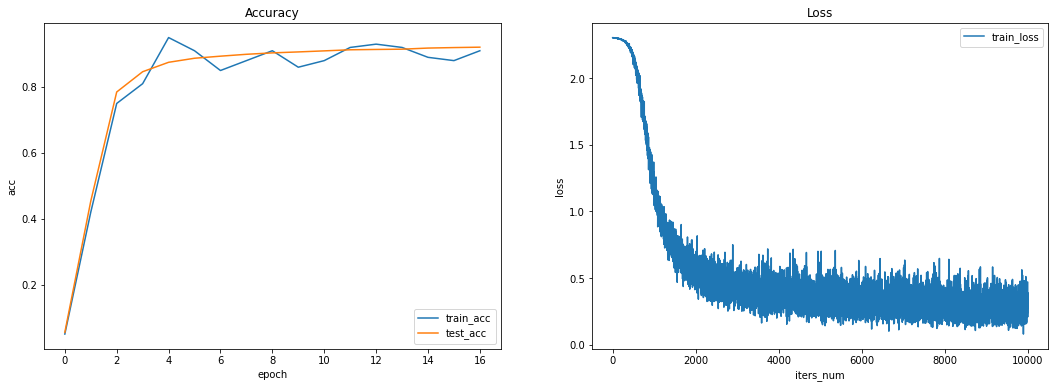

In [ ]:
epoch=np.arange(iters_num/iter_per_epoch)
iters=np.arange(iters_num)

fig=plt.figure(figsize=(18,6),facecolor='w')
ax=fig.add_subplot('121')
ax.plot(epoch,train_acc_list,label='train_acc')
ax.plot(epoch,test_acc_list,label='test_acc')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('Accuracy')
plt.legend(loc='lower right')

ax=fig.add_subplot('122')
ax.plot(iters,train_loss_list,label='train_loss')
ax.set_xlabel('iters_num')
ax.set_ylabel('loss')
ax.set_title('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
predict=network.predict(x_test)
predict_2=np.argmax(predict,axis=1)
print(predict_2[:10])
t_test_2=np.argmax(t_test,axis=1)
print(t_test_2[:10])

[7 2 1 0 4 1 4 9 6 9]
[7 2 1 0 4 1 4 9 5 9]


predict= 6
correct_label= 5


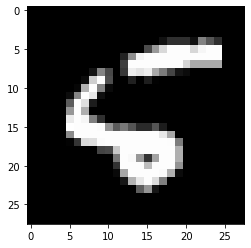

In [ ]:
img=x_test[8].reshape(28,28)
print('predict=',predict_2[8])
print('correct_label=',t_test_2[8])
plt.gray()
plt.imshow(img)
plt.show()